In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
def loc_eval(x, b):
    """
    Evaluate `x` using locally-weighted regression parameters.
    Degree of polynomial used in loess is inferred from b. `x`
    is assumed to be a scalar.
    """
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)



def loess(xvals, yvals, alpha, poly_degree=1):
    """
    Perform locally-weighted regression on xvals & yvals.
    Variables used inside `loess` function:

        n         => number of data points in xvals
        m         => nbr of LOESS evaluation points
        q         => number of data points used for each
                     locally-weighted regression
        v         => x-value locations for evaluating LOESS
        locsDF    => contains local regression details for each
                     location v
        evalDF    => contains actual LOESS output for each v
        X         => n-by-(poly_degree+1) design matrix
        W         => n-by-n diagonal weight matrix for each
                     local regression
        y         => yvals
        b         => local regression coefficient estimates.
                     b = `(X^T*W*X)^-1*X^T*W*y`. Note that `@`
                     replaces `np.dot` in recent numpy versions.
        local_est => response for local regression
    """
    # Sort dataset by xvals.
    all_data = sorted(zip(xvals, yvals), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)

    locsDF = pd.DataFrame(
                columns=[
                  'loc','x','weights','v','y','raw_dists',
                  'scale_factor','scaled_dists'
                  ])
    evalDF = pd.DataFrame(
                columns=[
                  'loc','est','b','v','g'
                  ])

    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = max(0,min(xvals)-(.5*avg_interval))
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)

    # Generate design matrix based on poly_degree.
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T


    for i in v:

        iterpos = i[0]
        iterval = i[1]

        # Determine q-nearest xvals to iterval.
        iterdists = sorted([(j, np.abs(j-iterval)) \
                           for j in xvals], key=lambda x: x[1])

        _, raw_dists = zip(*iterdists)

        # Scale local observations by qth-nearest raw_dist.
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 \
                      if j[1]<=1 else 0)) for j in scaled_dists]

        # Remove xvals from each tuple:
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))

        iterDF1 = pd.DataFrame({
                    'loc'         :iterpos,
                    'x'           :xvals,
                    'v'           :iterval,
                    'weights'     :weights,
                    'y'           :yvals,
                    'raw_dists'   :raw_dists,
                    'scale_fact'  :scale_fact,
                    'scaled_dists':scaled_dists
                    })

        locsDF    = pd.concat([locsDF, iterDF1])
        W         = np.diag(weights)
        y         = yvals
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'loc':[iterpos],
                       'b'  :[b],
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })

        evalDF = pd.concat([evalDF, iterDF2])

    # Reset indicies for returned DataFrames.
    locsDF.reset_index(inplace=True)
    locsDF.drop('index', axis=1, inplace=True)
    locsDF['est'] = 0; evalDF['est'] = 0
    locsDF = locsDF[['loc','est','v','x','y','raw_dists',
                     'scale_fact','scaled_dists','weights']]

    # Reset index for evalDF.
    evalDF.reset_index(inplace=True)
    evalDF.drop('index', axis=1, inplace=True)
    evalDF = evalDF[['loc','est', 'v', 'b', 'g']]

    return(locsDF, evalDF)

In [19]:
"""
Calling `loess` on a dataset that follows a known functional 
form with added random perturbations.
"""
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(16)

#xvals = [.39,.75,1.1,1.45,1.95,2.46,3.07,3.44,4.57,5.05,5.68,
#         6.01,6.63,7.11,7.62,8.01,8.54,9.08,9.48, 9.91]

#yvals = [1.25*np.sqrt(i)+np.random.normal(0, .425) for i in xvals]

data = pd.read_csv("/users/Sushanta/Documents/GitHub/Illinois/CS598 Practical Statistical Learning/Coding3_Data.csv")
xvals = list(data['x'])
yvals = list(data['y'])

# loess returns a tuple of DataFrames, named here as `regsDF` and
# `evalDF` for "Regression DataFrame" and "Evaluation DataFrame":
regsDF, evalDF = loess(xvals, yvals, alpha=.6, poly_degree=1)

In [4]:
evalDF

,loc,est,v,b,g
0,1,0,0.1520,"[0.4733571895014439, 0.4891106404247787]",0.547702
1,2,0,0.6518,"[0.47678756653565113, 0.487150108618323]",0.794312
2,3,0,1.1516,"[0.48037674793473517, 0.48492498295778286]",1.038816
3,4,0,1.6514,"[0.485086842277898, 0.4821198473808801]",1.281260
4,5,0,2.1512,"[0.4945196196321531, 0.47740844618366474]",1.521521
5,6,0,2.6510,"[0.5213688354577046, 0.4664800363800943]",1.758007
6,7,0,3.1508,"[0.632538630404035, 0.4303037130759719]",1.988340
7,8,0,3.6506,"[0.749802056773504, 0.3913697089300987]",2.178536
8,9,0,4.1504,"[0.8692435509085783, 0.36146702383232565]",2.369476
9,10,0,4.6502,"[1.1368057017842474, 0.30023374424407656]",2.532953


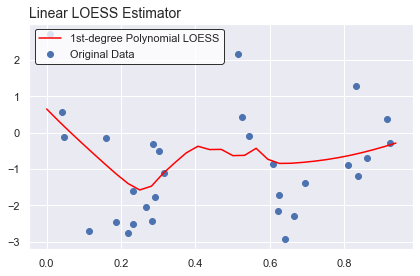

In [21]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='notebook', style='darkgrid', font_scale=1)

np.random.seed(16)

#xvals = [.39,.75,1.1,1.45,1.95,2.46,3.07,3.44,4.57,5.05,5.68,
#         6.01,6.63,7.11,7.62,8.01,8.54,9.08,9.48, 9.91]

#yvals = [1.25*np.sqrt(i)+np.random.normal(0, .425) for i in xvals]

data = pd.read_csv("/users/Sushanta/Documents/GitHub/Illinois/CS598 Practical Statistical Learning/Coding3_Data.csv")
xvals = list(data['x'])
yvals = list(data['y'])


regsDF, evalDF = loess(xvals, yvals, alpha=.6, poly_degree=1)

# Obtain reference to LOESS x & y values (v & g).
l_x  = evalDF['v'].values
l_y  = evalDF['g'].values

# Generate x-y scatterplot with loess estimate overlaid.
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.minorticks_on()
ax1.scatter(xvals, yvals, label="Original Data")
ax1.plot(l_x, l_y, color='#FF0000', label="1st-degree Polynomial LOESS")
ax1.set_title("Linear LOESS Estimator", loc="left", fontsize=14)
ax1.legend(loc="upper left",
           scatterpoints=1,
           fontsize=11,
           frameon=True,
           fancybox=True,
           facecolor="#FFFFFF",
           edgecolor="#000000")
plt.tight_layout()
plt.show()

In [46]:
data = pd.read_csv("/users/Sushanta/Documents/GitHub/Illinois/CS598 Practical Statistical Learning/Coding3_Data.csv")
x = list(data['x'])
y = list(data['y'])

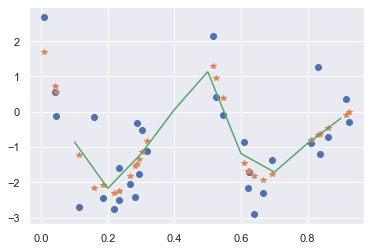

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
import statsmodels.api as sm

# introduce some floats in our x-values
#x = list(range(3, 33)) + [3.2, 6.2]
#y = [1,2,1,2,1,1,3,4,5,4,5,6,5,6,7,8,9,10,11,11,12,11,11,10,12,11,11,10,9,8,2,13]


data = pd.read_csv("/users/Sushanta/Documents/GitHub/Illinois/CS598 Practical Statistical Learning/Coding3_Data.csv")
x = list(data['x'])
y = list(data['y'])

# lowess will return our "smoothed" data with a y value for at every x-value
lowess = sm.nonparametric.lowess(y, x, frac=.3)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = [i/10. for i in range(400)]

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)


plt.plot(x, y, 'o')
plt.plot(lowess_x, lowess_y, '*')
plt.plot(xnew, ynew, '-')
plt.show()

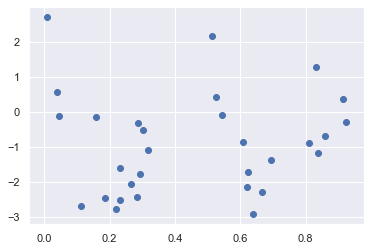

In [53]:
#spangcv.min = 0.5
plt.scatter(data['x'], data['y'])
#fx = 1:50/50;
#fy = sin(12*(fx+0.2))/(fx+0.2)
#lines(fx, fy, col=8, lwd=2);


In [58]:
fx = np.arange(1,51)/50
fy = np.sin(12*(fx+0.2))/(fx+0.2)

In [60]:
fy

array([ 2.18555734,  1.07758062,  0.08304221, -0.77383957, -1.47506814,
       -2.00937107, -2.37240514, -2.56666155, -2.60108224, -2.49041152,
       -2.25431851, -1.91633578, -1.50266689, -1.04092059, -0.558831  ,
       -0.08302286,  0.36212318,  0.75545607,  1.07985005,  1.32277977,
        1.47665555,  1.53891146,  1.51185088,  1.40226566,  1.22085558,
        0.98148347,  0.70030839,  0.39484392,  0.0829906 , -0.21790848,
       -0.49194282, -0.72539919, -0.90738134, -1.03025896, -1.08992914,
       -1.08588407, -1.02108825, -0.90167879, -0.73651016, -0.53657292,
       -0.31432093, -0.08294545,  0.14436394,  0.35513218,  0.53824865,
        0.68452163,  0.78711108,  0.84182051,  0.84723673,  0.80471481])

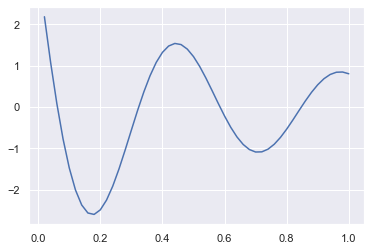

In [61]:
plt.plot(fx,fy)

In [63]:
import numpy as np
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
x = np.random.uniform(low = -2*np.pi, high = 2*np.pi, size=500)
y = np.sin(x) + np.random.normal(size=len(x))
z = lowess(y, x)
w = lowess(y, x, frac=1./3)

In [67]:
lowess.predict()

AttributeError: 'function' object has no attribute 'predict'